# ▒  Keras를 활용한 CNN 실습 ▒
    
## Mnist data 사용

### 필요한 모듈 불러오기

In [ ]:
import numpy as np
import pandas as pd

from tensorflow import keras
#from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras.models import Sequential  #모델 쌓기위해 필요한
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical  #정수인 y값 원핫인코딩하기 위해서

from keras.callbacks import ModelCheckpoint   # 최적의 모델을 선택

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#최적의 모수 저장해놓고 불러와야하니까 연동시켜놓은거임

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### MNIST 데이터 불러오기


In [ ]:
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
## generate validation data
np.random.seed(1234)
val_ind = np.random.choice(x_train.shape[0], 10000, replace=False)  # x_train.shape (6만*28*28) 6만개 중 validation 만개를 random해서 쓸거임. 복원추출은 없음
tr_ind = np.setdiff1d(np.arange(x_train.shape[0]),val_ind) # validaion을 제외한 나머지 5만개. setdiffe1d는 여집합 : x_train.shape[0]) - val_ind

x_valid, y_valid = x_train[val_ind], y_train[val_ind]
x_train, y_train = x_train[tr_ind], y_train[tr_ind]

### 데이터 확인하기

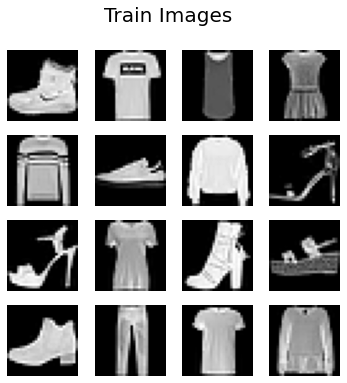

In [ ]:
# train 이미지 확인
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)                    # plt.subplot(row, column, index)
    plt.suptitle('Train Images', fontsize=20) # 하나의 큰 제목 설정
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.axis("off")

plt.show()

### 데이터 전처리하기
#### 입력값

  - -0.5 ~ 0.5 사이의 값을 갖도록 scaling
  - 3차원 tensor로 변환 (28×28×1)

#### 출력값 
  - One-hot encoding vector

In [ ]:
# Normalize the images.
x_train = (x_train / 255) - 0.5 # 0부터 255가지 정수로 이루어진 input값에서 그냥 0.5빼기 해줌.
x_valid = (x_valid / 255) - 0.5
x_test = (x_test / 255) - 0.5

# Reshape the images.
x_train = np.expand_dims(x_train, axis=3)  # axis=3 : 마지막 차원을 추가하고 싶엇기 때문에 4번째에 차원을 추가. (50000, 28, 28, 1)
x_valid = np.expand_dims(x_valid, axis=3)  # rgb는 애초에 3차원인데, gray는 아니라서 강제적으로 3차원으로 변화해줌. 28*28 -> 28*28*1 ( 3차원 이상의 메트릭스 : tensor로 바꿔줌 )
x_test = np.expand_dims(x_test, axis=3)

# One-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=10)  # 출력값 원핫인코딩 해줌. 
y_valid_onehot = to_categorical(y_valid, num_classes=10)
y_test_onehot = to_categorical(y_test, num_classes=10)

In [ ]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)


(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
filter_size = 3
pool_size = 2

# Build the model.      # sequetial 쌓아나가겠다는 것임. keras.input의 shape을 먼저 알려줌
model = Sequential([
  keras.Input(shape=(28,28,1)),
  ## padding='valid' or 'same'
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),  # convolution : 3*3짜리 50개를 써라. padding을 해라! => same
  BatchNormalization(),                                       # BatchNormalization
  Activation('relu'),                                         # Activation('relu')
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'), 
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D(pool_size=pool_size),                          # convolution 2단의 maxpooling 1단 [1번]

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 50, kernel_size = filter_size, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D(pool_size=pool_size),                          # convolution 2단의 maxpooling 1단 [2번]

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 50, kernel_size = filter_size, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D(pool_size=pool_size),                          # convolution 2단의 maxpooling 1단 [3번]

  Flatten(),
  Dense(50),
  Activation('relu'),
  Dropout(0.5),                                              # 50개의 node에 dropout를 함
  
  Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 28, 28, 50)        500       
                                                                 
 batch_normalization_47 (Bat  (None, 28, 28, 50)       200       
 chNormalization)                                                
                                                                 
 activation_70 (Activation)  (None, 28, 28, 50)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 28, 28, 50)        22550     
                                                                 
 batch_normalization_48 (Bat  (None, 28, 28, 50)       200       
 chNormalization)                                                
                                                                 
 activation_71 (Activation)  (None, 28, 28, 50)      

In [ ]:
checkpoint_filepath = "/content/gdrive/MyDrive/AI_class_2022_2/checkpoint/best_cnn.ckpt"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,    # ModelCheckpoint : 최적의 성능을 갖는 모형을 저장, weight(모수값)만 저장할래
    monitor='val_accuracy',    # 어떤 값을 기준으로 최적 모델을 할ㄹ?                       ###### 'val_loss'
    mode='max',                # validation 어떤 기준으로 할래? accuracy는 max,             ######  mode = 'min'   loss는 최소
    save_best_only=True,       # best만 필요함
    verbose=1)                 # 어떻게 진행되는지 보여줘라~~~~~ 1은 어는정도 보여줌


In [ ]:

# Compile the model.                               # 어떤 목적함수를 쓸건지, 그걸 최적화하기 위해 어떤 알고리즘을 쓸건지, 추가로 보여주는 건 accuracy를 보여줘랑
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

# Train the model.
history = model.fit(x=x_train,y=y_train_onehot, 
          epochs=10, 
          validation_data=(x_valid, y_valid_onehot),
          verbose=1,
          batch_size=128, 
          callbacks=[model_checkpoint_callback]    # call back : 최적의 모델을 저장하고 나중에 사용하기 위해서, 아까 만들었던 것을 리스트 형태로 저장
)


Epoch 1/10
388/391 [============================>.] - ETA: 0s - loss: 0.7216 - accuracy: 0.7514
Epoch 1: val_accuracy improved from -inf to 0.59710, saving model to /content/gdrive/MyDrive/AI_class_2022_2/checkpoint/best_cnn.ckpt
391/391 [==============================] - 35s 86ms/step - loss: 0.7202 - accuracy: 0.7517 - val_loss: 1.2045 - val_accuracy: 0.5971
Epoch 2/10
388/391 [============================>.] - ETA: 0s - loss: 0.4277 - accuracy: 0.8507
Epoch 2: val_accuracy improved from 0.59710 to 0.88020, saving model to /content/gdrive/MyDrive/AI_class_2022_2/checkpoint/best_cnn.ckpt
391/391 [==============================] - 7s 17ms/step - loss: 0.4278 - accuracy: 0.8507 - val_loss: 0.3359 - val_accuracy: 0.8802
Epoch 3/10
390/391 [============================>.] - ETA: 0s - loss: 0.3589 - accuracy: 0.8754
Epoch 3: val_accuracy improved from 0.88020 to 0.89930, saving model to /content/gdrive/MyDrive/AI_class_2022_2/checkpoint/best_cnn.ckpt
391/391 [==============================

### 결과 확인

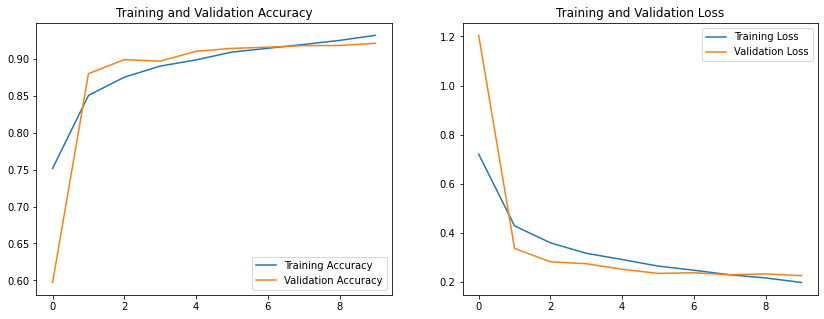

In [ ]:
# accuracy, loss 그래프

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### 최적의 성능을 갖는 모형 로드하기
- 불러온 모형의 성능 확인

In [ ]:
# Load the model from disk later using:
model.load_weights(checkpoint_filepath)      

In [ ]:
model.evaluate(x_test, y_test_onehot)    # loss와 accuracy 반환

313/313 [==============================] - 1s 4ms/step - loss: 0.2433 - accuracy: 0.9174


[0.2433329075574875, 0.9174000024795532]

In [ ]:
y_pred_enc = model.predict(x_test)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값

In [ ]:
item = {
      0: 'T-shirt/top'
    , 1: 'Trouser'
    , 2: 'Pullover'
    , 3: 'Dress'
    , 4: 'Coat'
    , 5: 'Sandal'
    , 6: 'Shirt'
    , 7: 'Sneaker'
    , 8: 'Bag'
    , 9: 'Ankle boot'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,906,0,18,13,1,1,58,0,3,0
Trouser,2,985,1,8,1,0,2,0,1,0
Pullover,16,2,853,4,73,0,52,0,0,0
Dress,17,0,8,905,52,0,17,0,1,0
Coat,0,0,16,10,917,0,57,0,0,0
Sandal,0,0,0,0,0,979,0,12,0,9
Shirt,140,1,36,21,77,0,722,0,3,0
Sneaker,0,0,0,0,0,8,0,976,0,16
Bag,4,2,4,2,2,9,3,6,967,1
Ankle boot,0,0,1,0,0,3,0,32,0,964
